In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import h5py
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [2]:
f = h5py.File('./data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

In [3]:
features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']

In [4]:
features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))
df = pd.concat([features_df,labels_df],axis=1)
df = df.drop_duplicates()


In [5]:
MaxParticles = 100
# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), MaxParticles, len(features) - 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles > MaxParticles:
        features_val_i = features_val_i[0:MaxParticles, :]
    else:
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles - nParticles, len(features) - 1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval


In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)

In [7]:
# Normalization
reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0] * X_train_val.shape[1], X_train_val.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train_val.shape[1]):
    X_train_val[:, p, :] = scaler.transform(X_train_val[:, p, :])
    X_test[:, p, :] = scaler.transform(X_test[:, p, :])
if 'j_index' in labels:
        labels = labels[:-1]

In [8]:
l1Reg = 0.0001

In [19]:
model = models.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(100, 7)))
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv1D)        (None, 100, 32)           8992      
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 50)                160050    
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 255       
Total params: 251,281
Trainable params: 251,281
Non-trainable params: 0
________________________________________________

In [22]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_val, y_train_val, epochs=100)

Train on 19852 samples
Epoch 1/100
19852/19852 [==============================] - 32s 2ms/sample - loss: 0.4735 - accuracy: 0.9453
Epoch 2/100
19852/19852 [==============================] - 31s 2ms/sample - loss: 0.2253 - accuracy: 0.9628
Epoch 3/100
19852/19852 [==============================] - 32s 2ms/sample - loss: 0.1576 - accuracy: 0.9715
Epoch 4/100
19852/19852 [==============================] - 32s 2ms/sample - loss: 0.1188 - accuracy: 0.9766
Epoch 5/100
19852/19852 [==============================] - 31s 2ms/sample - loss: 0.0981 - accuracy: 0.9792
Epoch 6/100
19852/19852 [==============================] - 31s 2ms/sample - loss: 0.0903 - accuracy: 0.9809
Epoch 7/100
19852/19852 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.98 - 31s 2ms/sample - loss: 0.0837 - accuracy: 0.9825
Epoch 8/100
19852/19852 [==============================] - 31s 2ms/sample - loss: 0.0775 - accuracy: 0.9845
Epoch 9/100
19852/19852 [==============================] - 31s 2ms/samp

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0.25, 0.9, 'Conv_1d_notebook_version')

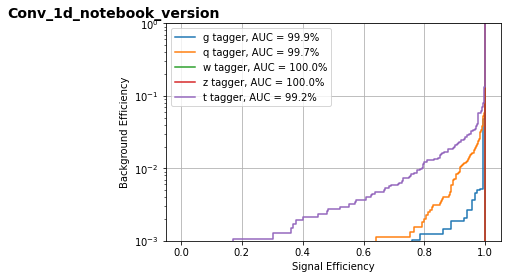

In [18]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)